# Post Assessment 2
You are tasked with building a predictive model for a supermarket to forecast total sales per transaction. Accurate sales predictions will help the supermarket optimize inventory management, staffing, and overall business strategy. 

The dataset for this project is publicly available on Kaggle: https://www.kaggle.com/datasets/faresashraf1001/supermarket-sales

## Project Objectives 

- Analyze the dataset and identify patterns that affect total sales. 

- Build machine learning models to predict total sales. 

- Evaluate model performance and select the best-performing model. 

- Provide actionable insights that could support business decision-making. 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from time import strptime, strftime
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

from pylab import rcParams

from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import OneHotEncoder

## Read in Sales Data

In [2]:
df= pd.read_csv("./archive/SuperMarket Analysis.csv")
# df= pd.read_csv("./archive/SuperMarket Analysis.csv", index_col='Date', parse_dates= ["Date"])

In [3]:
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00 AM,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,1:23:00 PM,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,8:33:00 PM,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00 AM,Ewallet,604.17,4.761905,30.2085,5.3


## Initial Info and Statistics 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Sales                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

* Date and Time are in the wrong Dtype
* No missing data
* Column Headers need to be clean

In [5]:
df.describe()

,Unit price,Quantity,Tax 5%,Sales,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,0.000000,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905,49.650000,10.00000


In [6]:
df.describe(include="O", exclude=["int", "float"])

,Invoice ID,Branch,City,Customer type,Gender,Product line,Date,Time,Payment
count,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,1000,3,3,2,2,6,89,506,3
top,750-67-8428,Alex,Yangon,Member,Female,Fashion accessories,2/7/2019,7:48:00 PM,Ewallet
freq,1,340,340,565,571,178,20,7,345


* Gross Margin Percentage is 4.761905
* Invoive ID

Both have high cardinality and uniqueness, will be dropped

In [7]:
print("Number of Duplicate Rows", df.duplicated().sum())

Number of Duplicate Rows 0


## Wrangle Data and Clean

In [8]:
# fix column names

cols= [col.lower().replace(" ", "_") for col in df.columns]
df.columns= cols

In [9]:
# Reformat the date values from / to - then 
df= df.copy()
df["date"]= pd.to_datetime(df['date'], format = '%m/%d/%Y') #.dt.date

df.date.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: date
Non-Null Count  Dtype         
--------------  -----         
1000 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 7.9 KB


In [10]:
# Reformat the time values from / to - then 

df["time"]= pd.to_datetime(df['time'], format ='%I:%M:%S %p').dt.strftime('%H:%M:%S')
df.time.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: time
Non-Null Count  Dtype 
--------------  ----- 
1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [11]:
# Merge date and time columns

# df["datetime"]= pd.DataFrame({"datetime": df["date"].astype(str).str.cat(df["time"].astype(str), sep= " ")})
# df["datetime"]= pd.to_datetime(df.datetime)

# Merge date and time into one string, then convert to datetime 
df["datetime"] = pd.to_datetime(df["date"].astype(str) + " " + df["time"].astype(str))

In [12]:
df.datetime.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: datetime
Non-Null Count  Dtype         
--------------  -----         
1000 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 7.9 KB


In [13]:
# convert Dataframe to timeseries data

df.set_index("datetime", inplace=True)

In [14]:
# Drop highly unique and cardinal columns, date and time columns
 
# df.drop(columns=["invoice_id", "gross_margin_percentage"], axis=1, inplace= True)
df.drop(columns=["invoice_id", "gross_margin_percentage", "date", "time"], axis=1, inplace= True)

In [15]:
df.index = pd.to_datetime(df.index)
df = df.sort_index() 
print(df.index.is_unique)   # should be True

False


## EDA

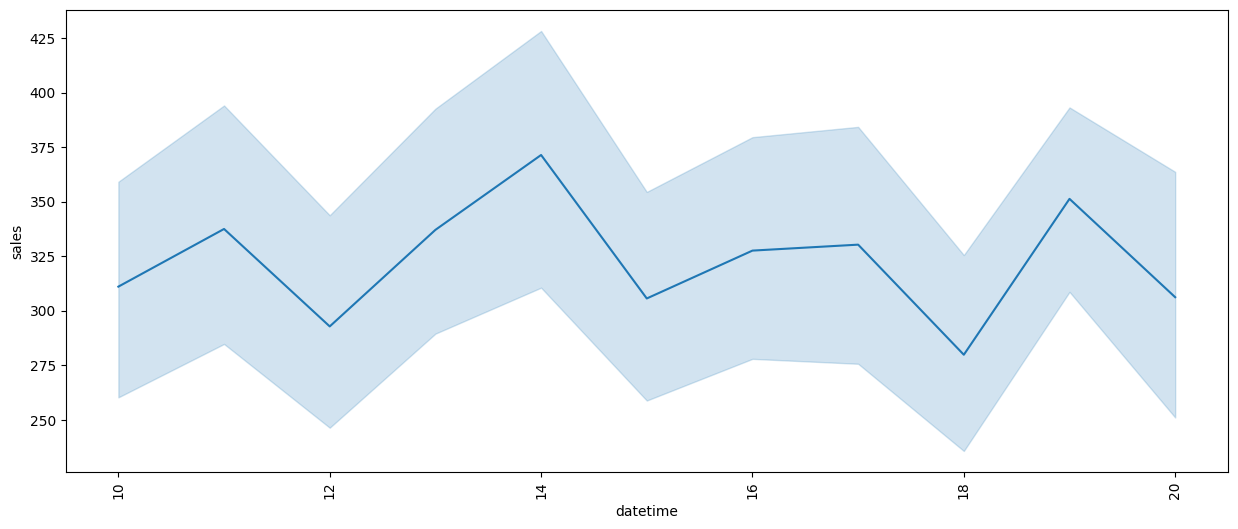

In [16]:
plt.figure(figsize=(15,6))
ax = sns.lineplot(data=df, x=df.index.hour, y="sales")

plt.xticks(rotation= 90)
plt.show()

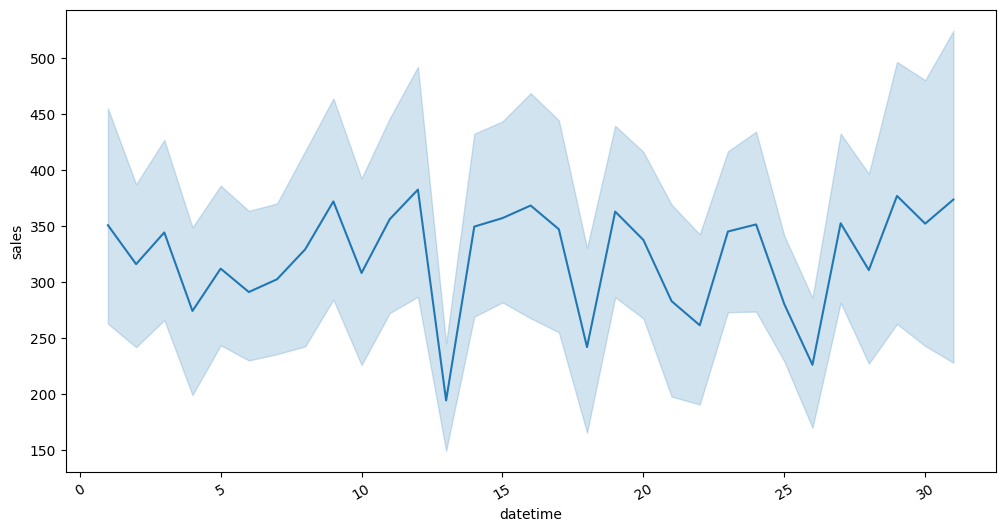

In [17]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index.day, y="sales")
plt.xticks(rotation= 30);

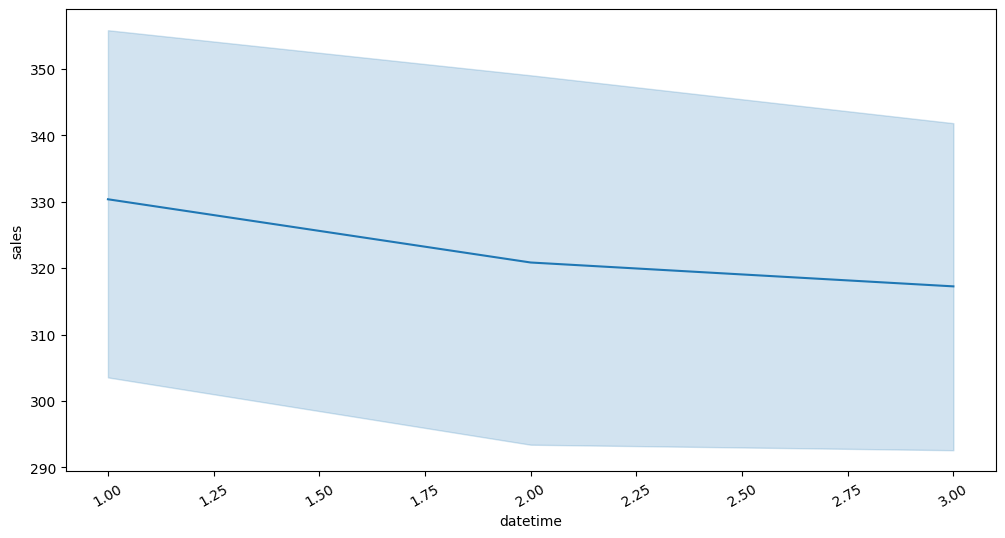

In [18]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index.month, y="sales")
plt.xticks(rotation= 30)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

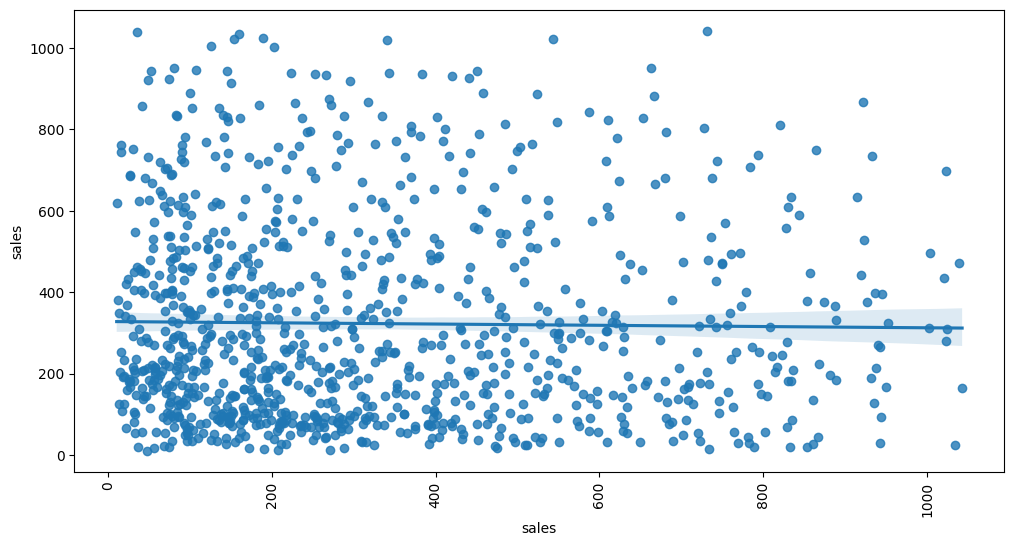

In [19]:
plt.figure(figsize=(12,6))
sns.regplot(data= df, x= df.sales.shift(1), y= "sales")
plt.xticks(rotation= 90)
plt.show

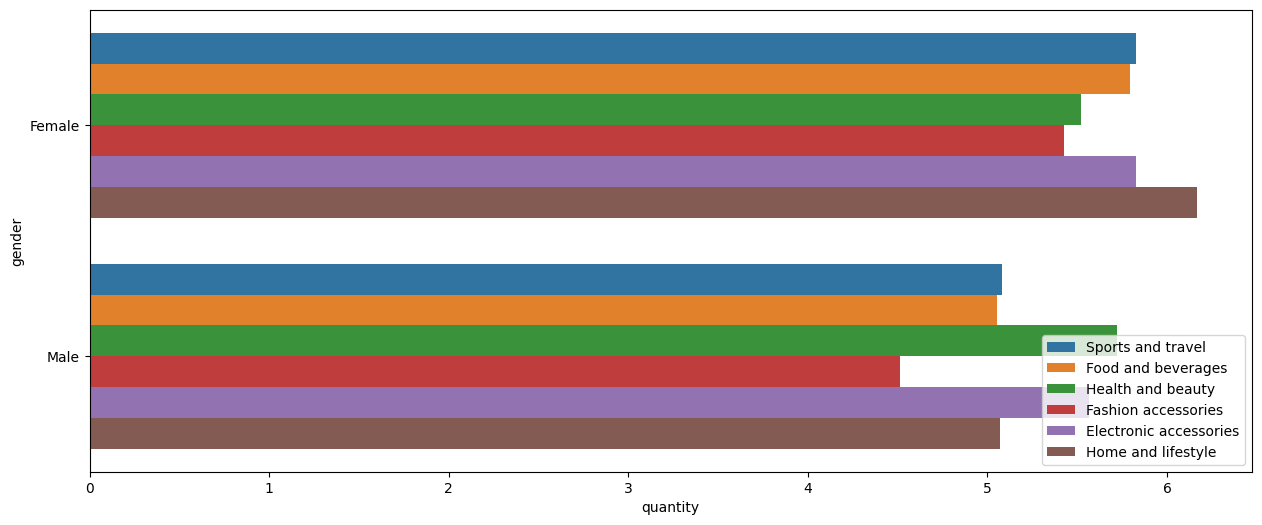

In [20]:
plt.figure(figsize=(15, 6))
sns.barplot(data= df, x="quantity", y="gender", hue="product_line", errorbar=None) 
# plt.xticks(rotation= 30)
plt.legend()
plt.show()

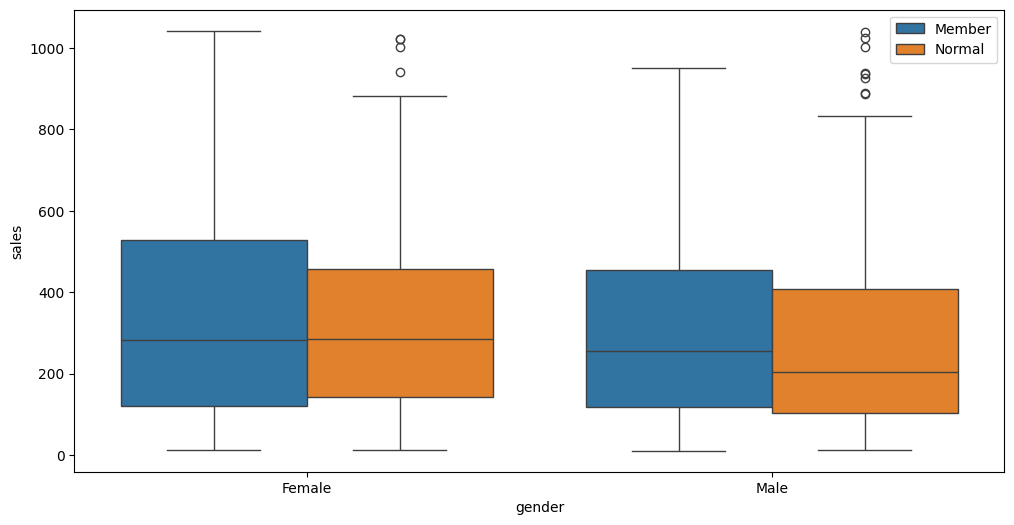

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(data= df, x="gender", y="sales", hue="customer_type")
plt.legend()
plt.show()

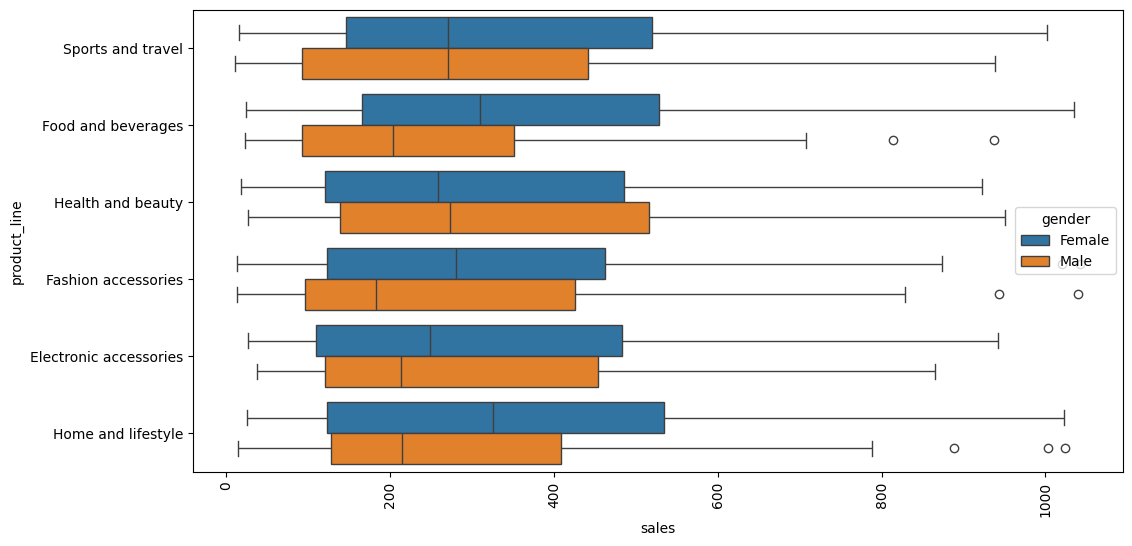

In [22]:
plt.figure(figsize=(12, 6))
sns.boxplot(data= df, x="sales", y="product_line", hue="gender")
plt.xticks(rotation=90)
plt.show()

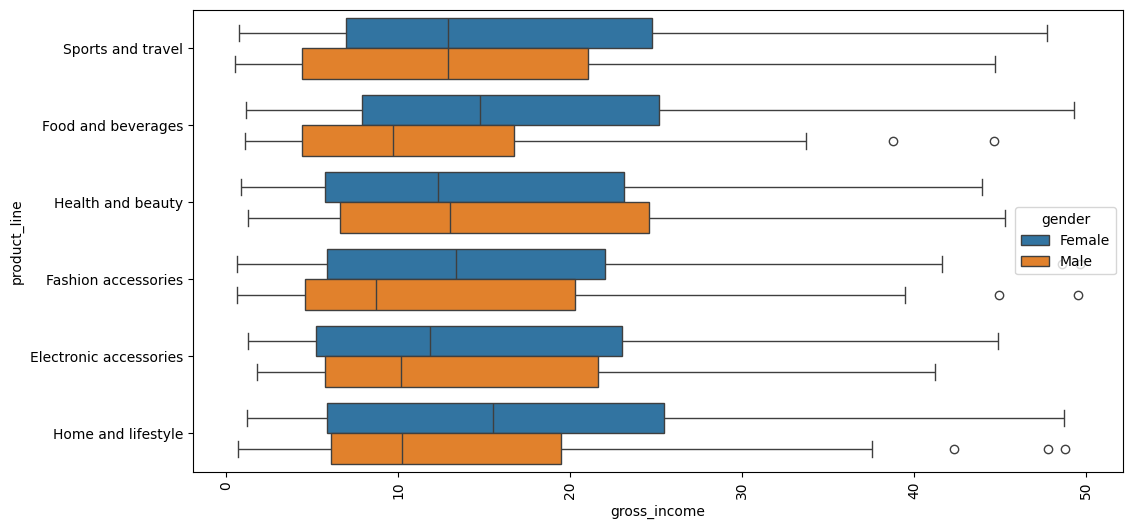

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(data= df, x="gross_income", y="product_line", hue="gender")
plt.xticks(rotation=90)
plt.show()

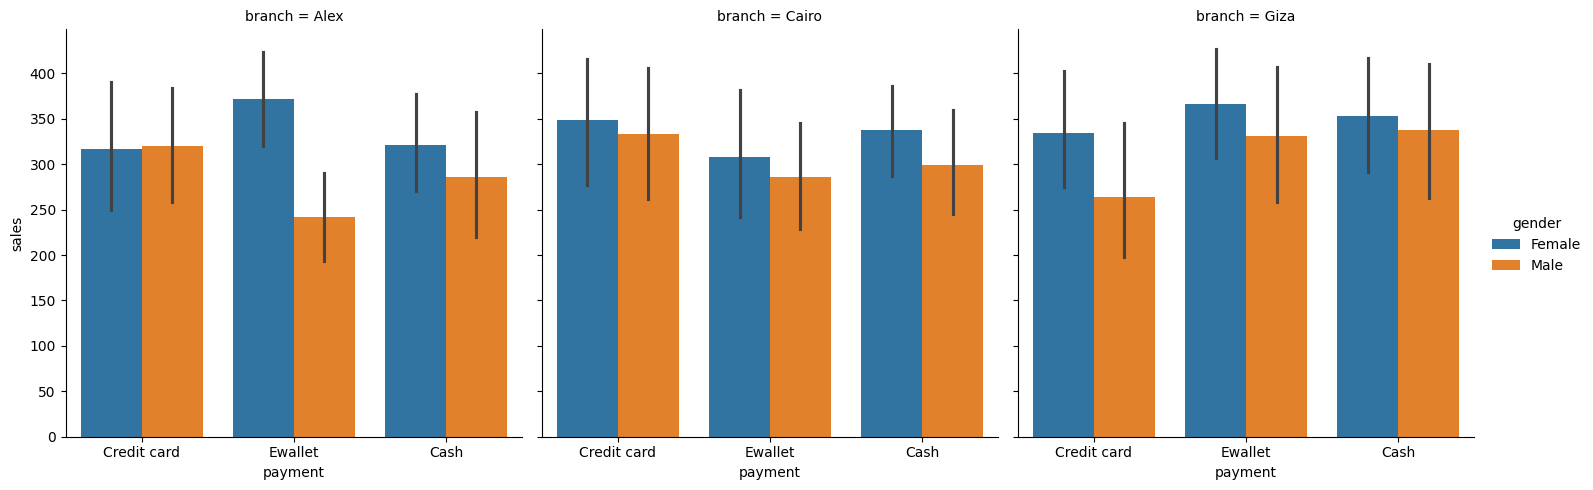

In [24]:
sns.catplot(data=df, x="payment", y="sales", col='branch', kind="bar", hue="gender")

<Axes: xlabel='gross_income', ylabel='product_line'>

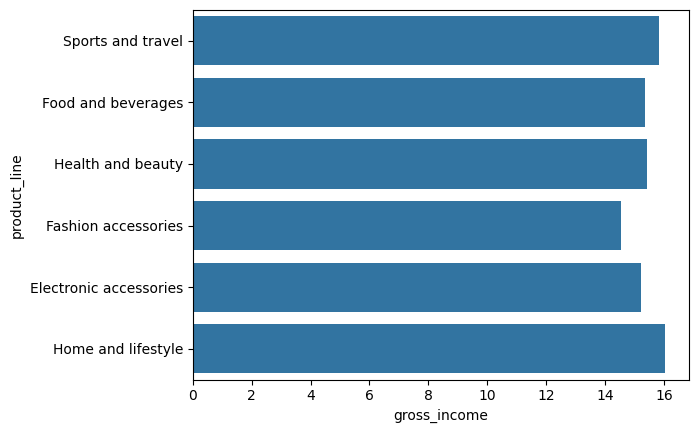

In [25]:
sns.barplot(data=df, x="gross_income", y="product_line", errorbar=None)

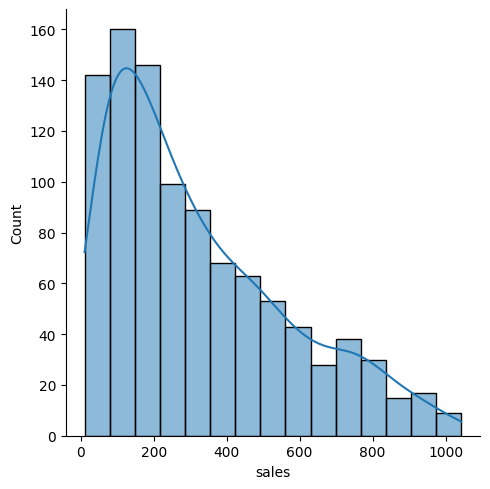

In [26]:
sns.displot(data= df, x='sales', kde="kde")
plt.show()

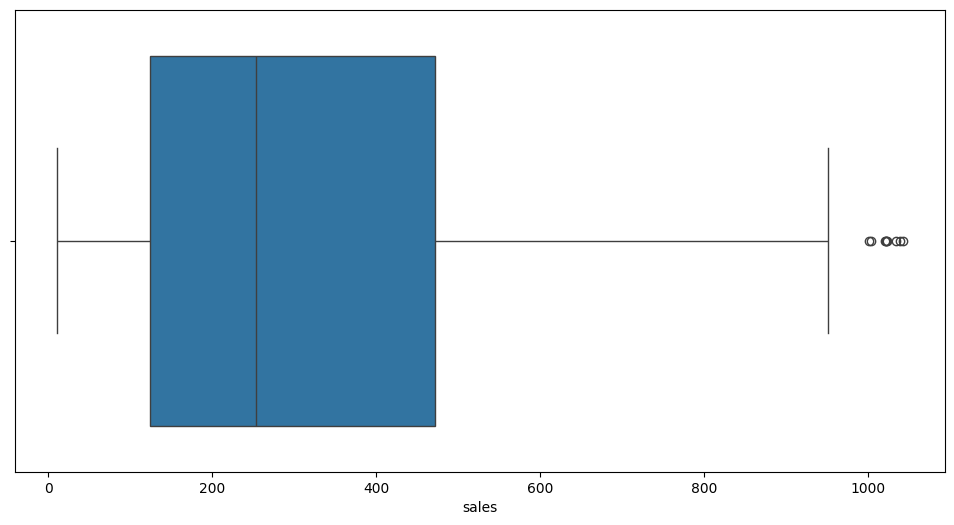

In [27]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df["sales"])
plt.show()

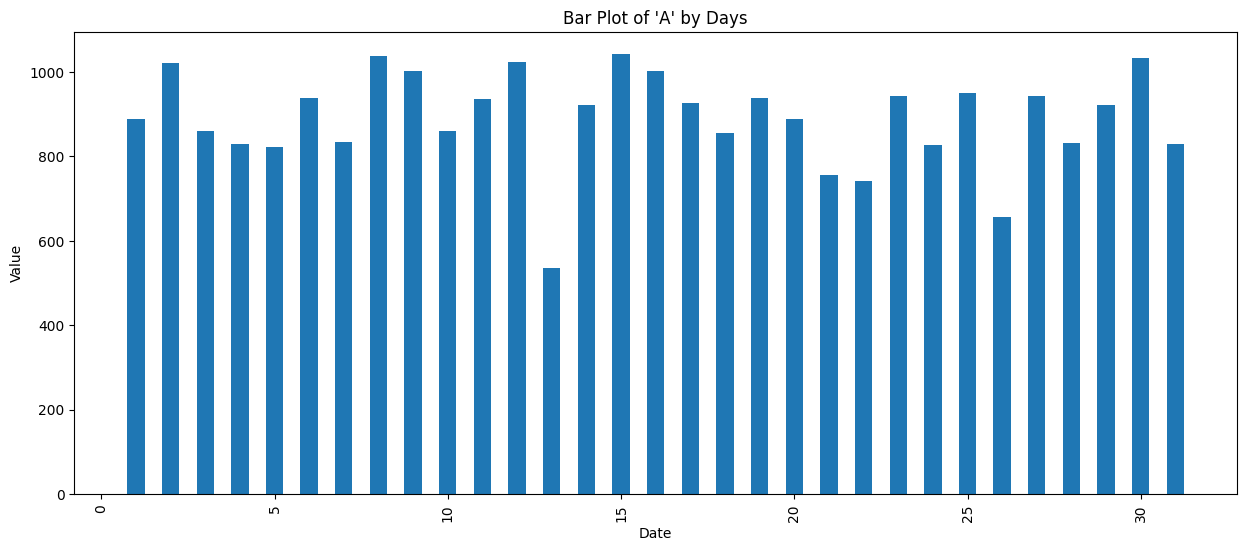

In [28]:
plt.figure(figsize=(15, 6))
plt.bar(df.index.day, df["sales"], width=0.5)
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Bar Plot of 'A' by Days")
plt.xticks(rotation=90)
plt.show()

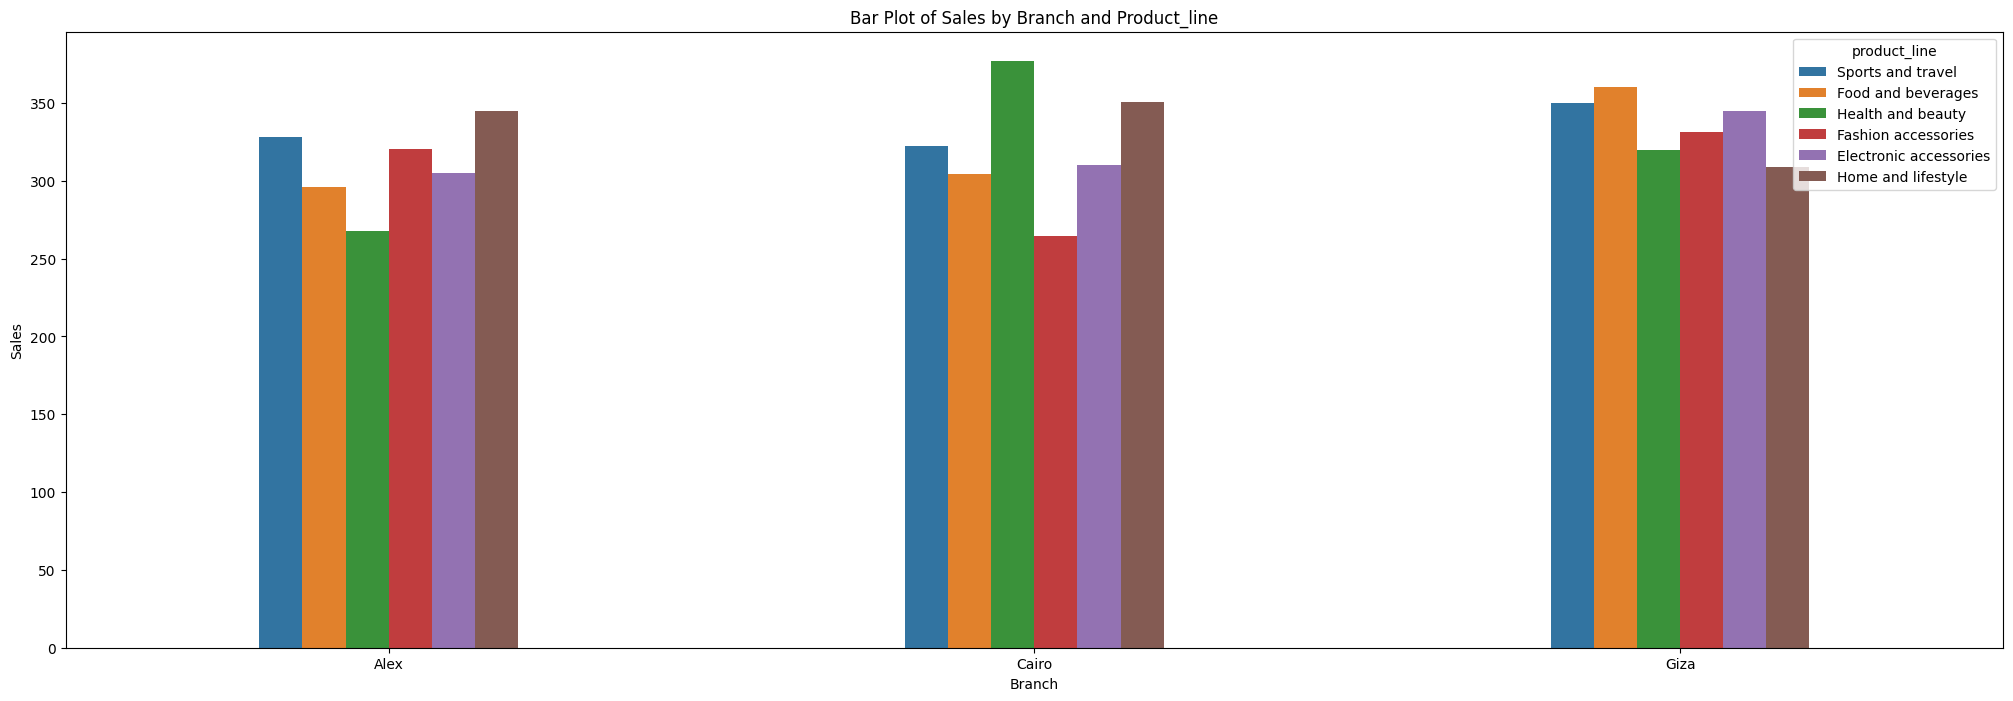

In [29]:
plt.figure(figsize=(25, 8))
sns.barplot(df, x="branch", y="sales", width=0.4, errorbar=None, hue="product_line")
plt.xlabel("Branch")
plt.ylabel("Sales")
plt.title("Bar Plot of Sales by Branch and Product_line")
# plt.xticks(rotation=90)
plt.show()

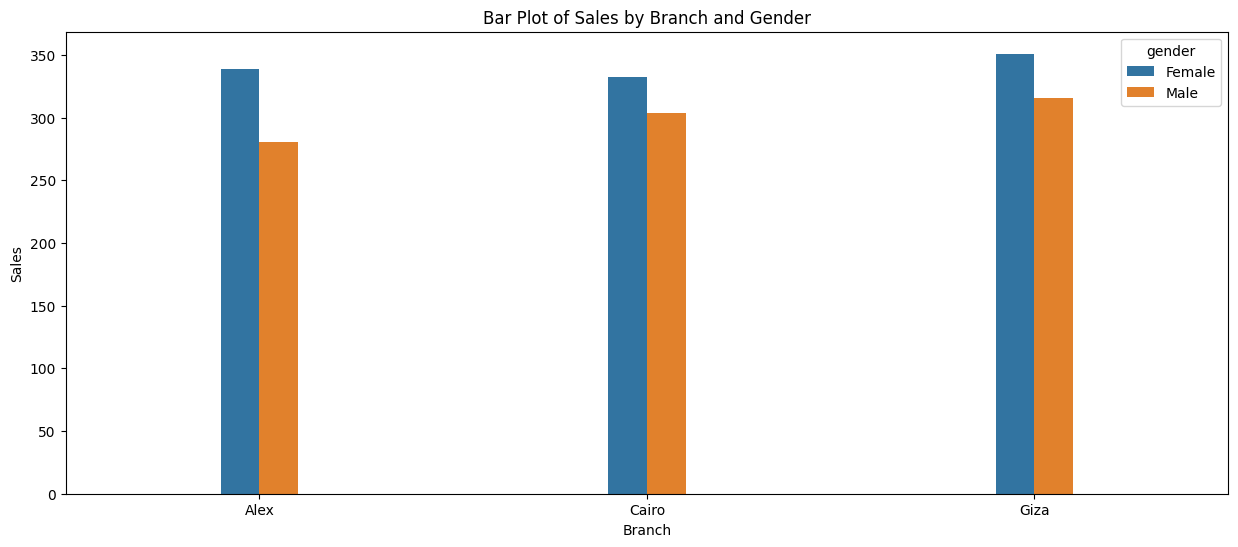

In [30]:
plt.figure(figsize=(15, 6))
sns.barplot(df, x="branch", y="sales", width=0.2, errorbar=None, hue="gender")
plt.xlabel("Branch")
plt.ylabel("Sales")
plt.title("Bar Plot of Sales by Branch and Gender")
# plt.xticks(rotation=90)
plt.show()

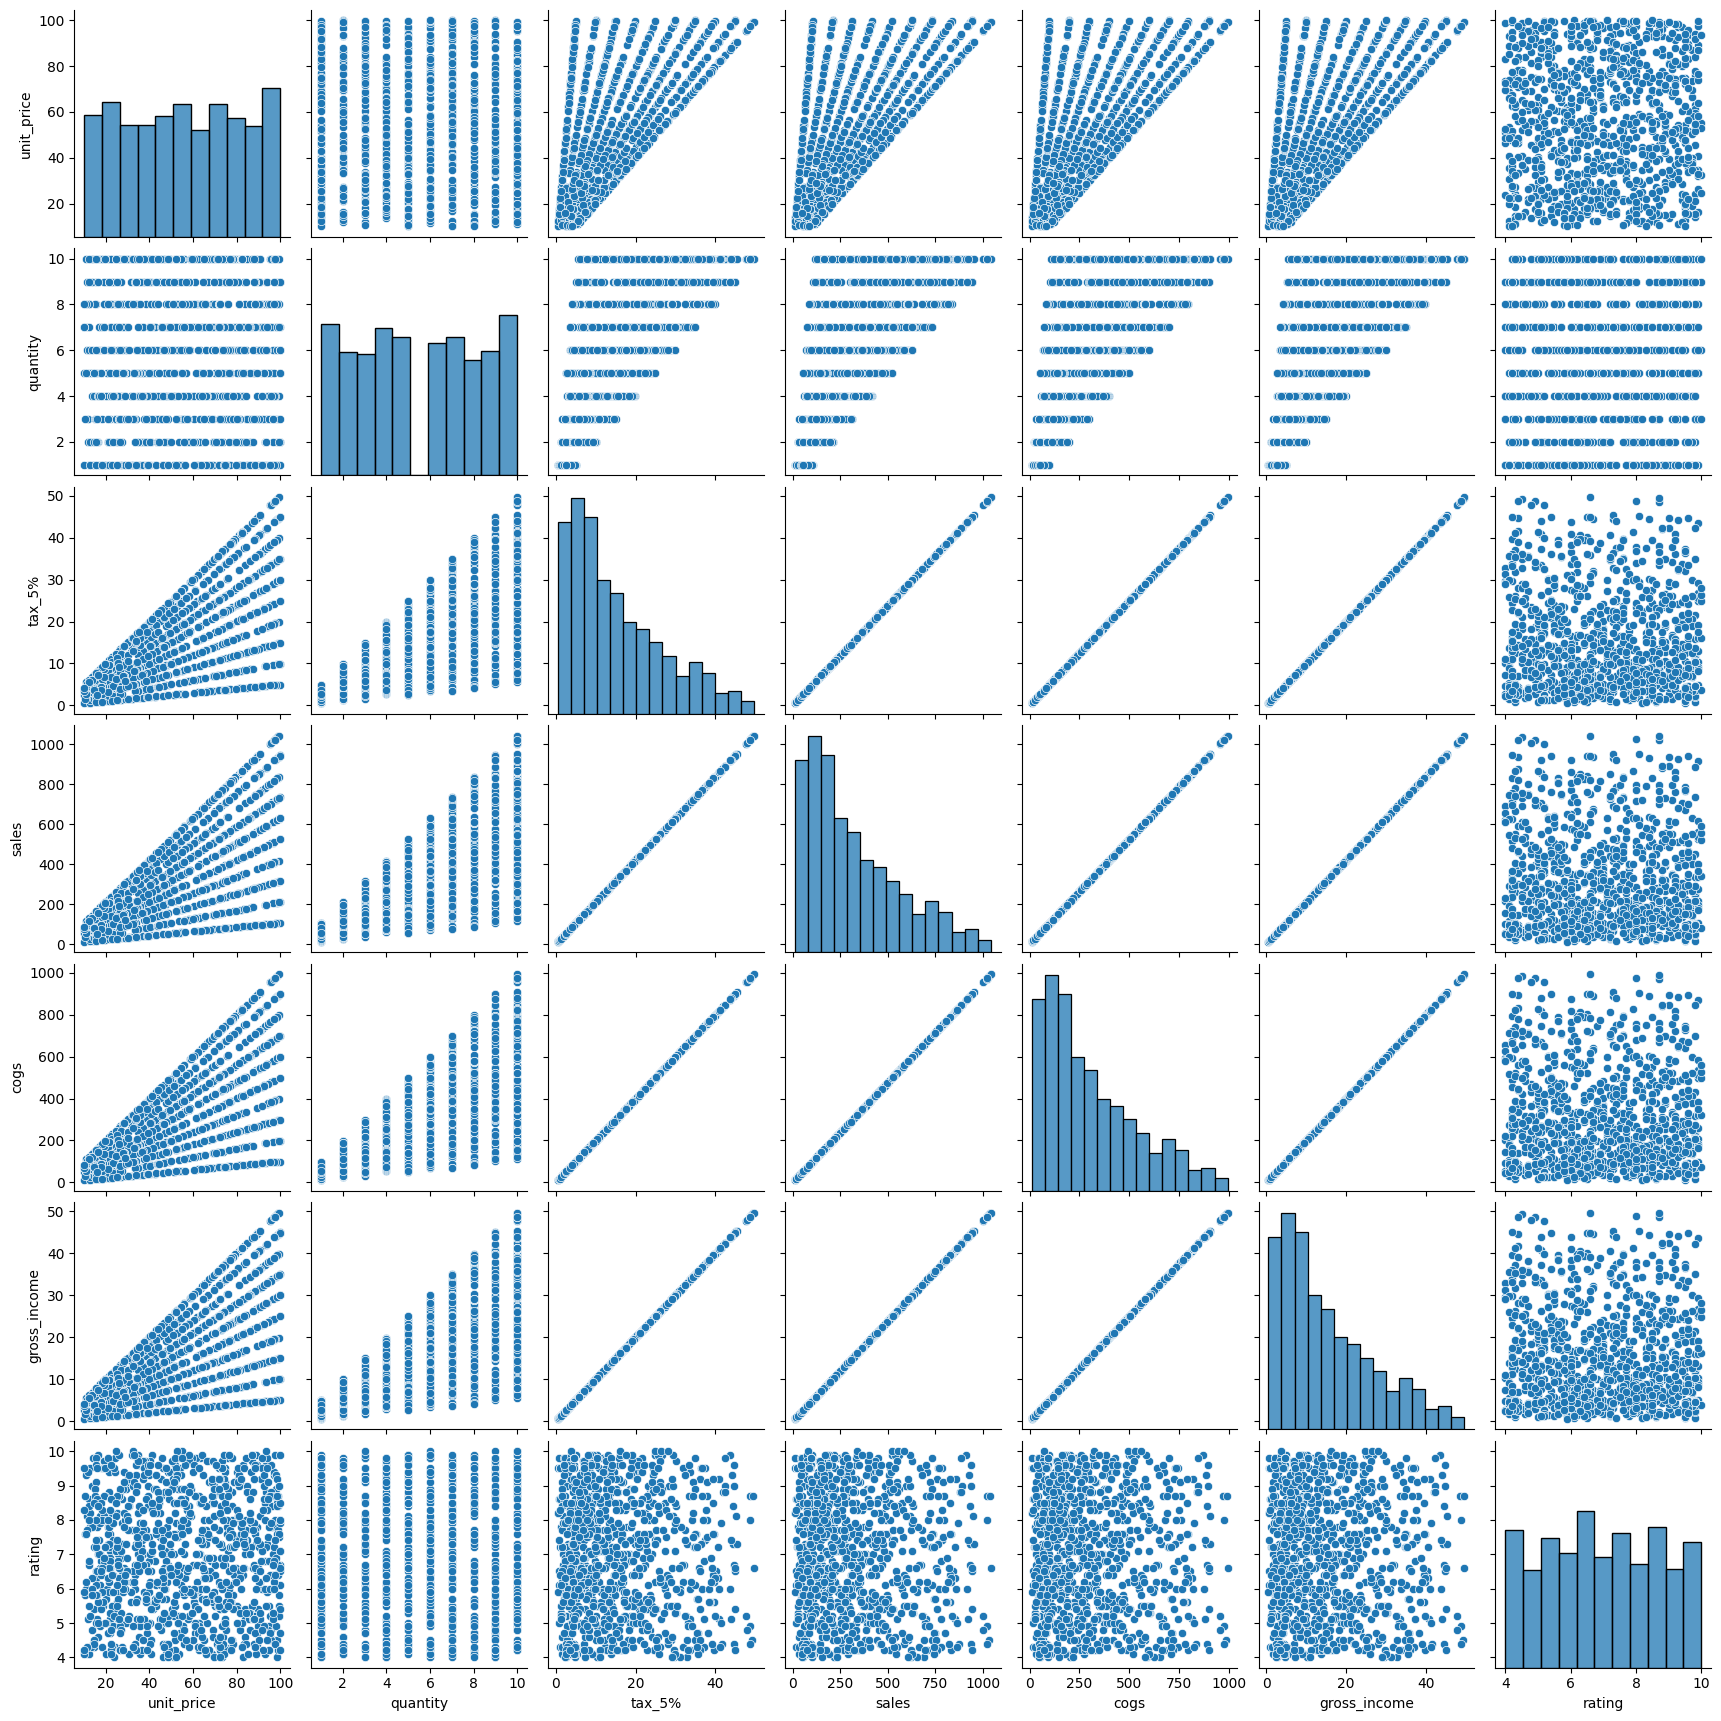

In [31]:
sns.pairplot(df.select_dtypes(include=np.number));

In [32]:
# sns.pairplot(df.select_dtypes(include="number"), x_vars=df.gender, y_vars=df.product_line );

<Figure size 1200x600 with 0 Axes>

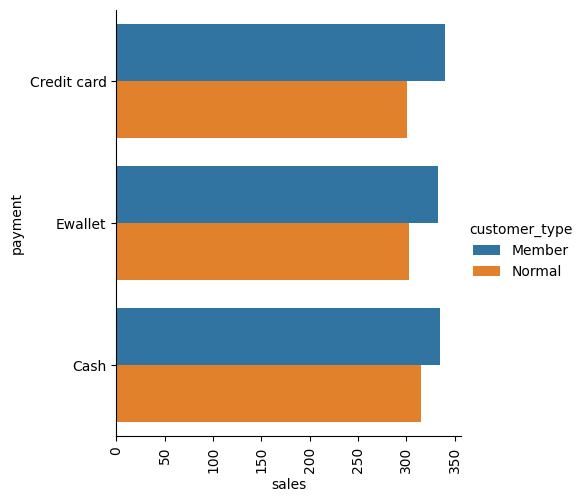

In [33]:
plt.figure(figsize=(12, 6))
sns.catplot(data= df, x="sales", y="payment", hue="customer_type", kind="bar", errorbar=None)
plt.xticks(rotation=90)
plt.show()

<Axes: >

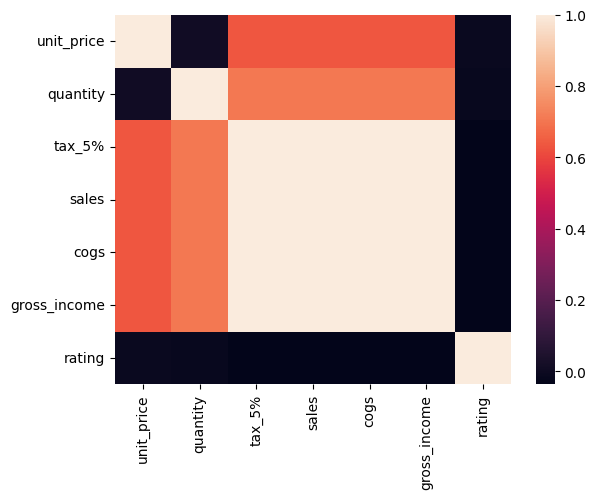

In [34]:
corr= df.corr(numeric_only=True)
sns.heatmap(corr)

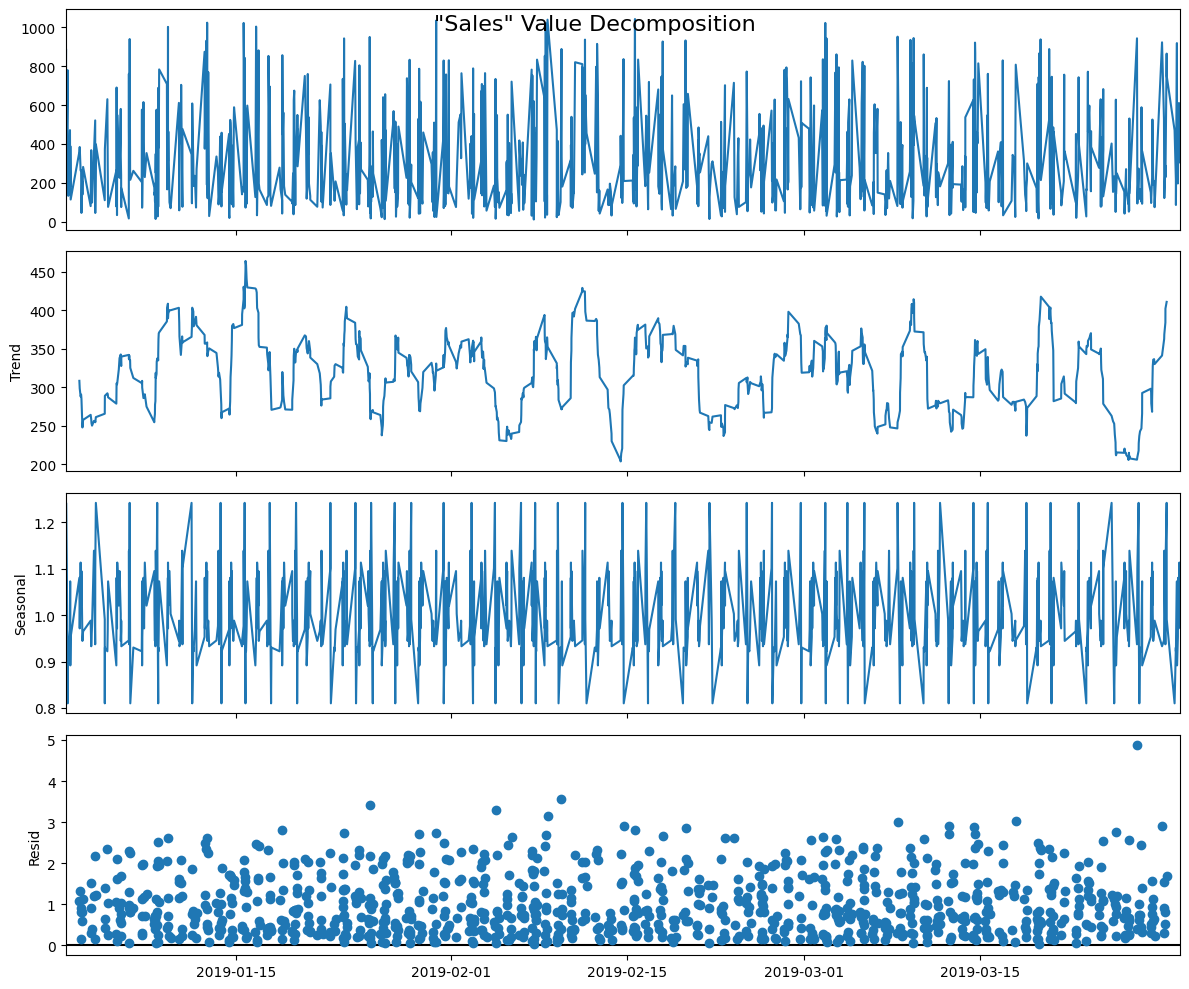

In [35]:
# Seasonal decomposition : daily

decomp_data = df[['sales']].copy()
decomp_data.index= pd.to_datetime(decomp_data.index)

decomposition = sm.tsa.seasonal_decompose(decomp_data, model='multiplicative', period=24)
rcParams['figure.figsize'] = 12, 10
decomposition.plot()
plt.suptitle('"Sales" Value Decomposition', fontsize=16)
plt.show()

In [36]:
# df_datetime["roll_mean_1"] = df_datetime["sales"].rolling(1).mean()
# df_datetime["roll_mean_7"] = df_datetime["sales"].rolling(7).mean()
# df_datetime["roll_mean_30"] = df_datetime["sales"].rolling(30).mean()

# df["roll_mean_1"] = df["sales"].rolling(1).mean()
# df["roll_mean_7"] = df["sales"].rolling(7).mean()
# df["roll_mean_30"] = df["sales"].rolling(30).mean()

In [37]:
# df["sales"] = df["sales"].interpolate(method="time")

In [38]:
# plt.figure(figsize=(14,5))
# sns.lineplot(x=df.index.day, y=df["sales"], label="Sales", alpha=0.5, color="black")
# sns.lineplot(x=df.index.day, y=df["roll_mean_1"], label="1-day rolling mean", color="orange")
# sns.lineplot(x=df.index.day, y=df["roll_mean_7"], label="7-day rolling mean", color="purple")
# sns.lineplot(x=df.index.day, y=df["roll_mean_30"], label="30-day rolling mean", color="blue")
# plt.title("Sales vs 1,7, and 30-day rolling mean")
# plt.legend(); plt.grid(True); plt.show()

In [39]:
# # Rolling Mean

# plt.figure(figsize=(12, 6))
# plt.plot(df_datetime["sales"], label="Original sales")
# plt.plot(df_datetime["sales"].rolling(window=2, min_periods=1).mean(), label="Rolling Mean (2)")
# plt.xlabel("Date")
# plt.ylabel("Value")
# plt.title("Rolling Mean Plot")
# plt.legend()
# plt.show()

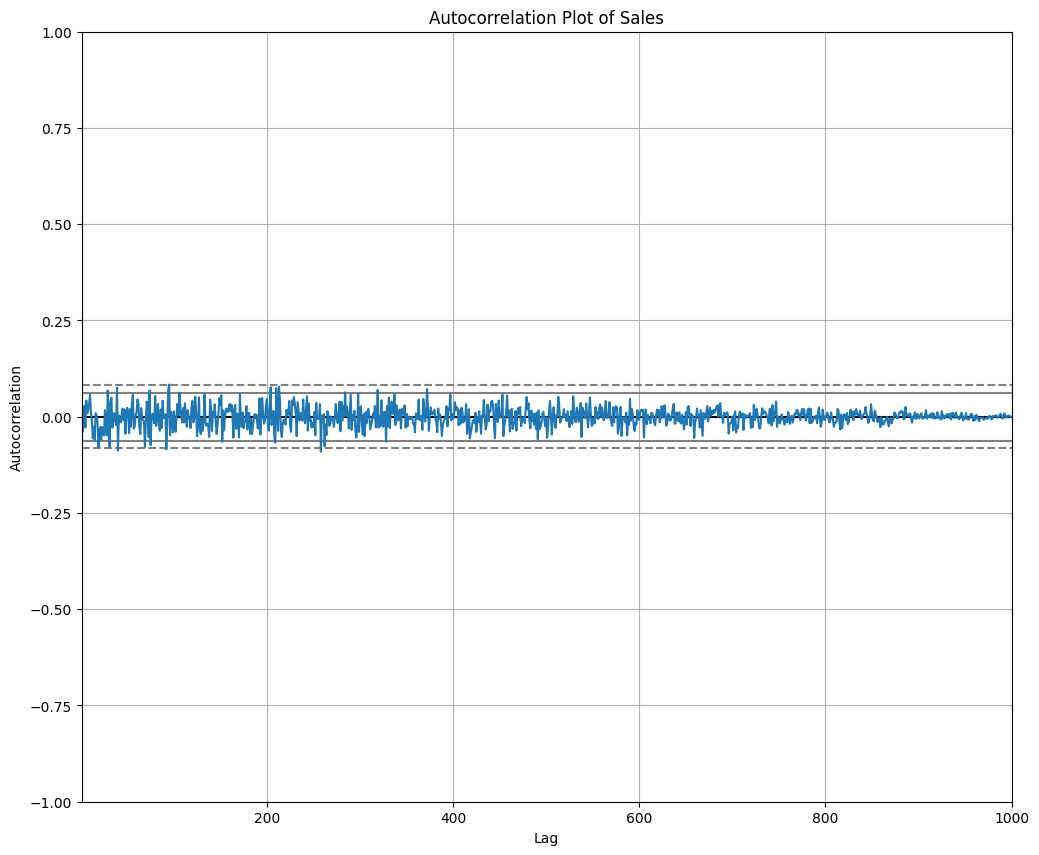

In [40]:
# Autocorrelation

autocorrelation_plot(df.sales)
plt.title('Autocorrelation Plot of Sales')
plt.show()

In [41]:
#  Daily change ratio
# df["change"] = df["sales"].div(df["sales"].shift(3))

In [42]:
# plt.figure(figsize=(12,6))
# sns.lineplot(x=df.index, y=df["change"])
# plt.axhline(1, color="red", linestyle="--")  # baseline (no change)
# plt.show()

<Figure size 800x400 with 0 Axes>

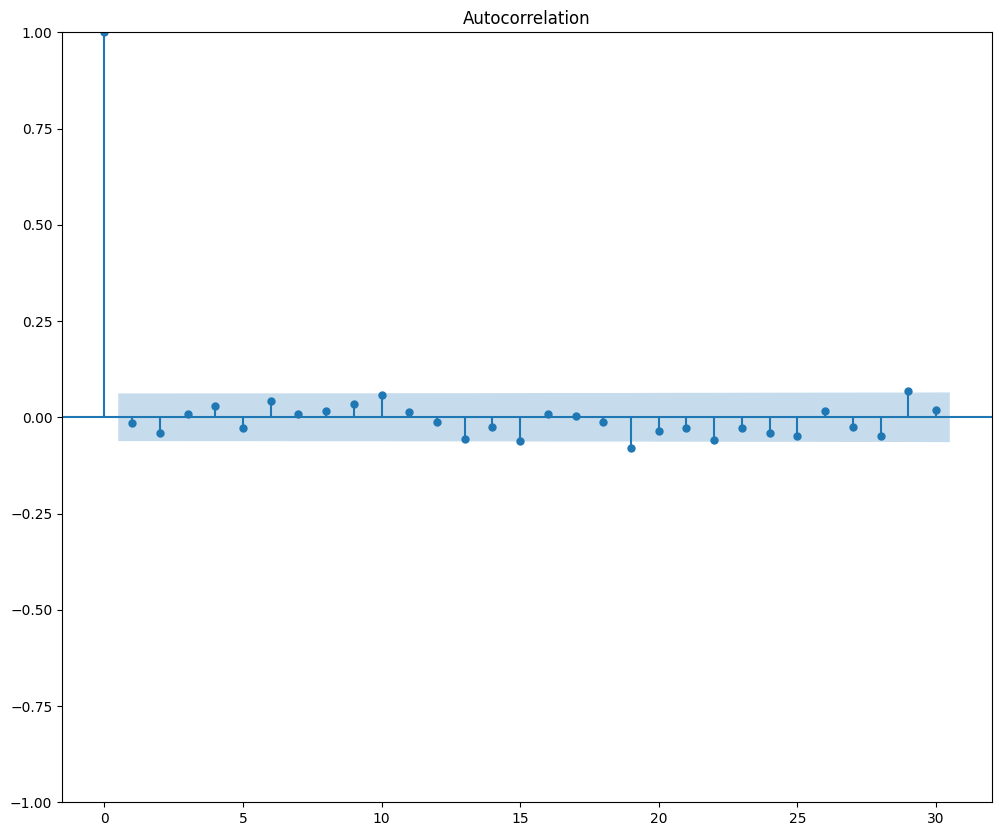

In [43]:
plt.figure(figsize= (8,4))
plot_acf(df["sales"], lags=30) 
plt.show();

<Figure size 800x400 with 0 Axes>

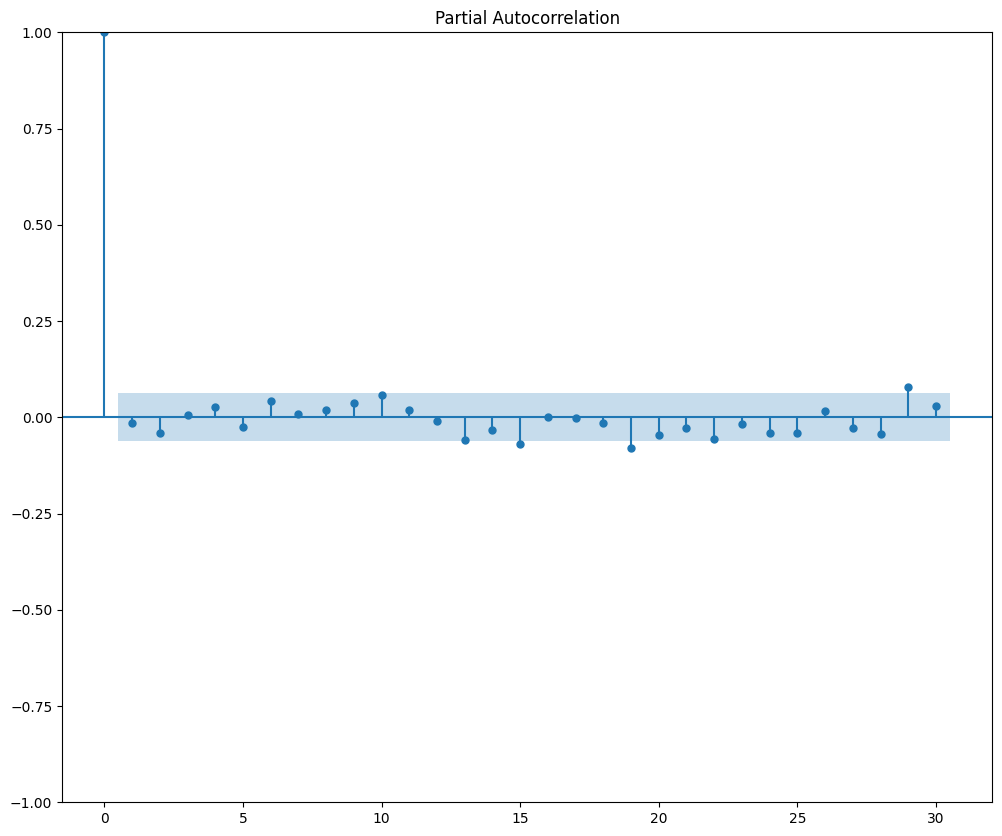

In [44]:
plt.figure(figsize= (8,4))
plot_pacf(df["sales"], lags=30, method="ywm") 
plt.show()

## Feature Engineering

In [45]:
# check for duplicates
print("Duplicate Dates in Dataset", df.duplicated().sum())
print("Duplicate Dates in Index:", df.index.duplicated().sum())

Duplicate Dates in Dataset 0
Duplicate Dates in Index: 6


In [46]:
# Drop Duplicalets in Index
# df = df[~df.index.duplicated(keep="first")]
# print("Duplicate Dates in Index:", df.index.duplicated().sum())

In [47]:
# daily_sales = df.asfreq(freq="D")

In [48]:
# print("Frequency of DateTimeIndex: ", daily_sales.index.freq)

In [49]:
# Datetimeindex to Periodindex

# df.index= df.index.to_period(freq="D")

In [50]:
# print(df.index.freq)

In [51]:
# df.index.unique

In [52]:
### Adding Time Features dataset
# df["hour"]= df.index.hour
# df["day"]= df.index.day
# df["month"]= df.index.month

In [53]:
# dummy= pd.get_dummies(df.select_dtypes(include="object"), dtype='int')
# df= pd.concat([df, dummy], axis=1)

In [54]:
# df_clean= df.drop(columns= df.select_dtypes(include='object').columns)

In [55]:
# df_clean.info()

In [56]:
# corr= df_clean.corr(numeric_only=True)
# sns.heatmap(corr);

#### Groupby DateTimeIndex

In [57]:

# df_datetime = df.groupby(df.index.date).agg({ "unit_price": "mean", 
#                                               "quantity": "sum", 
#                                               "tax_5%": "sum", 
#                                               "sales": "sum", 
#                                               "cogs": "sum", 
#                                               "gross_income": "sum", 
#                                               "rating": "mean" })
# df_datetime.index = pd.to_datetime(df_datetime.index)

In [58]:
# df_datetime = df_datetime.asfreq("D")

In [59]:
# Aggregate transactions into daily totals

df_daily = df.resample('D').agg({ "unit_price": "mean", 
                                  "quantity": "sum", 
                                  "tax_5%": "sum", 
                                  "sales": "sum", 
                                  "cogs": "sum", 
                                  "gross_income": "sum", 
                                  "rating": "mean" })
# df_daily.index = pd.to_datetime(df_daily.index)

In [62]:
print("Unique Index: ", df_daily.index.is_unique)   # should be True

print("Frequency: ", df_daily.index.freq)   # should show <Day>

Unique Index:  True
Frequency:  <Day>


In [63]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 89 entries, 2019-01-01 to 2019-03-30
Freq: D
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit_price    89 non-null     float64
 1   quantity      89 non-null     int64  
 2   tax_5%        89 non-null     float64
 3   sales         89 non-null     float64
 4   cogs          89 non-null     float64
 5   gross_income  89 non-null     float64
 6   rating        89 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 7.6 KB


In [64]:
df_daily.head()

,unit_price,quantity,tax_5%,sales,cogs,gross_income,rating
datetime,,,,,,,
2019-01-01,54.995833,81,225.9610,4745.1810,4519.22,225.9610,6.583333
2019-01-02,44.635000,48,92.6430,1945.5030,1852.86,92.6430,6.050000
2019-01-03,59.457500,37,98.9585,2078.1285,1979.17,98.9585,8.112500
2019-01-04,51.743333,32,77.3185,1623.6885,1546.37,77.3185,6.516667
2019-01-05,61.636667,55,168.4135,3536.6835,3368.27,168.4135,7.433333


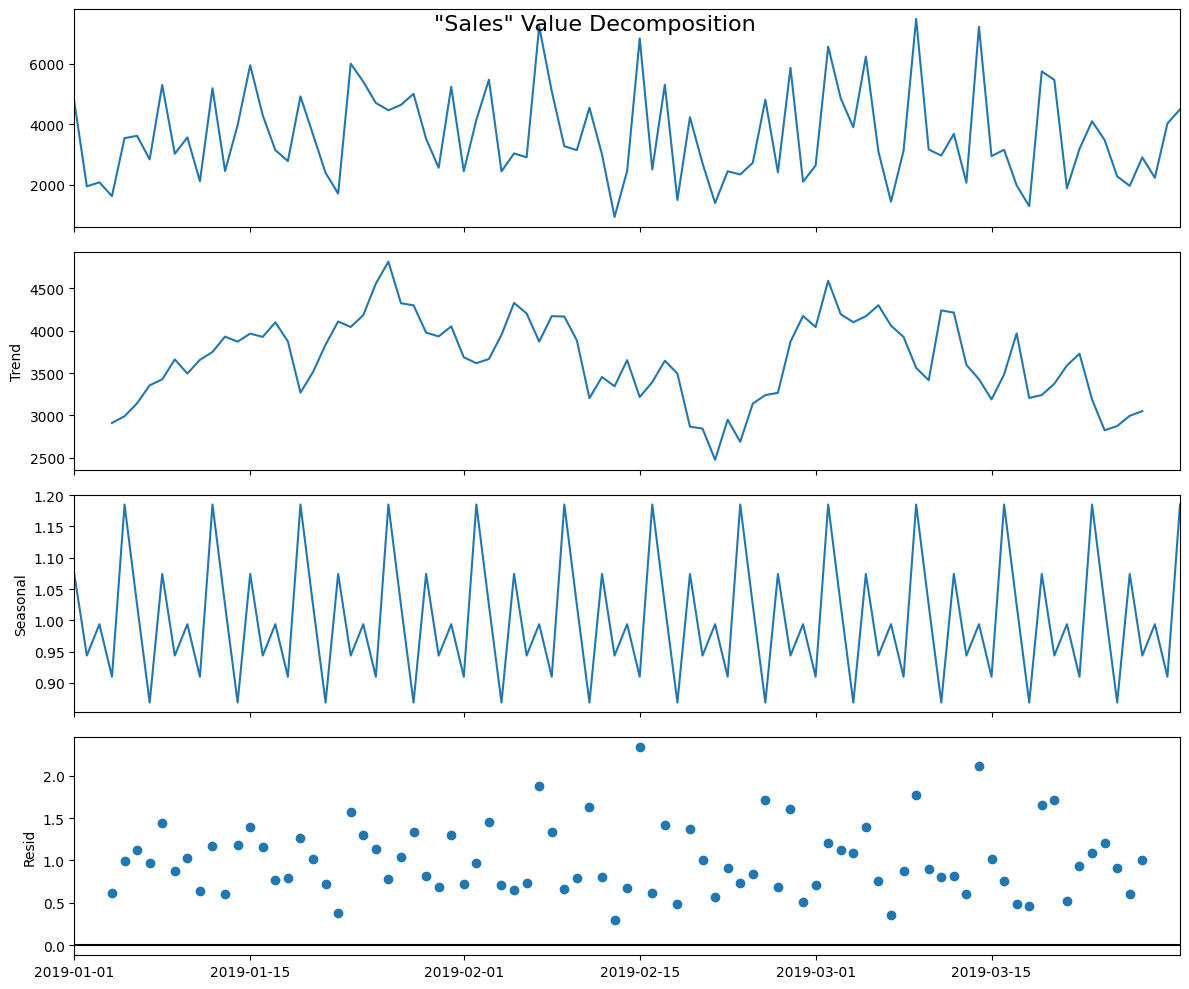

In [73]:
# Seasonal decomposition : daily

decomp_data = df_daily[['sales']].copy()
decomp_data.index= pd.to_datetime(decomp_data.index)

decomposition = sm.tsa.seasonal_decompose(decomp_data, model='multiplicative', period=7)
rcParams['figure.figsize'] = 12, 10
decomposition.plot()
plt.suptitle('"Sales" Value Decomposition', fontsize=16)
plt.show()

In [66]:

df_daily["roll_mean_1"] = df_daily["sales"].rolling(1).mean()
df_daily["roll_mean_7"] = df_daily["sales"].rolling(7).mean()
df_daily["roll_mean_30"] = df_daily["sales"].rolling(30).mean()

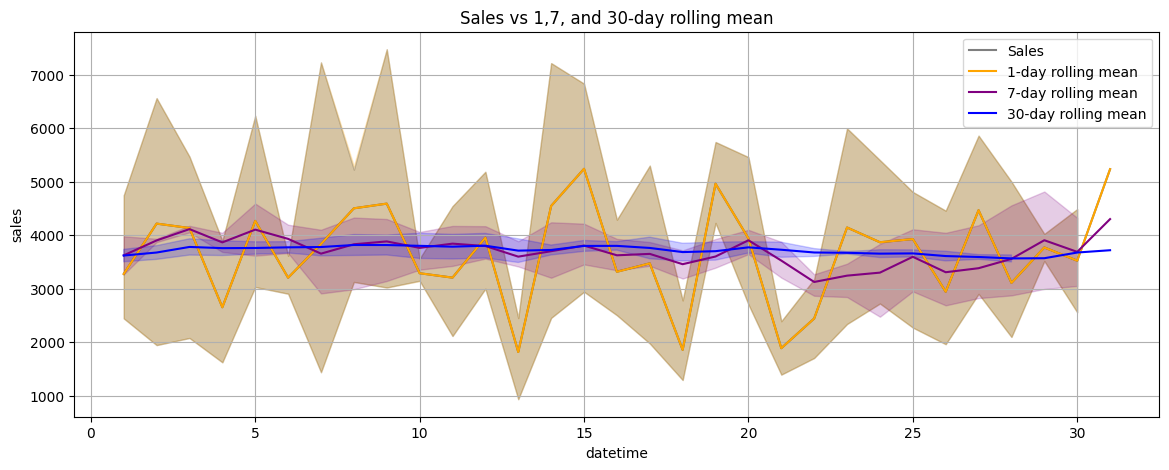

In [67]:
plt.figure(figsize=(14,5))
sns.lineplot(x=df_daily.index, y=df_daily["sales"], label="Sales", alpha=0.5, color="black")
sns.lineplot(x=df_daily.index, y=df_daily["roll_mean_1"], label="1-day rolling mean", color="orange")
sns.lineplot(x=df_daily.index, y=df_daily["roll_mean_7"], label="7-day rolling mean", color="purple")
sns.lineplot(x=df_daily.index, y=df_daily["roll_mean_30"], label="30-day rolling mean", color="blue")
plt.title("Sales vs 1,7, and 30-day rolling mean")
plt.legend(); plt.grid(True); plt.show()

**The purple line (7-day mean)** smooths the jagged edges, showing weekly cycles.

**The blue line (30-day mean)** is the smoothest, revealing the overall trend direction.

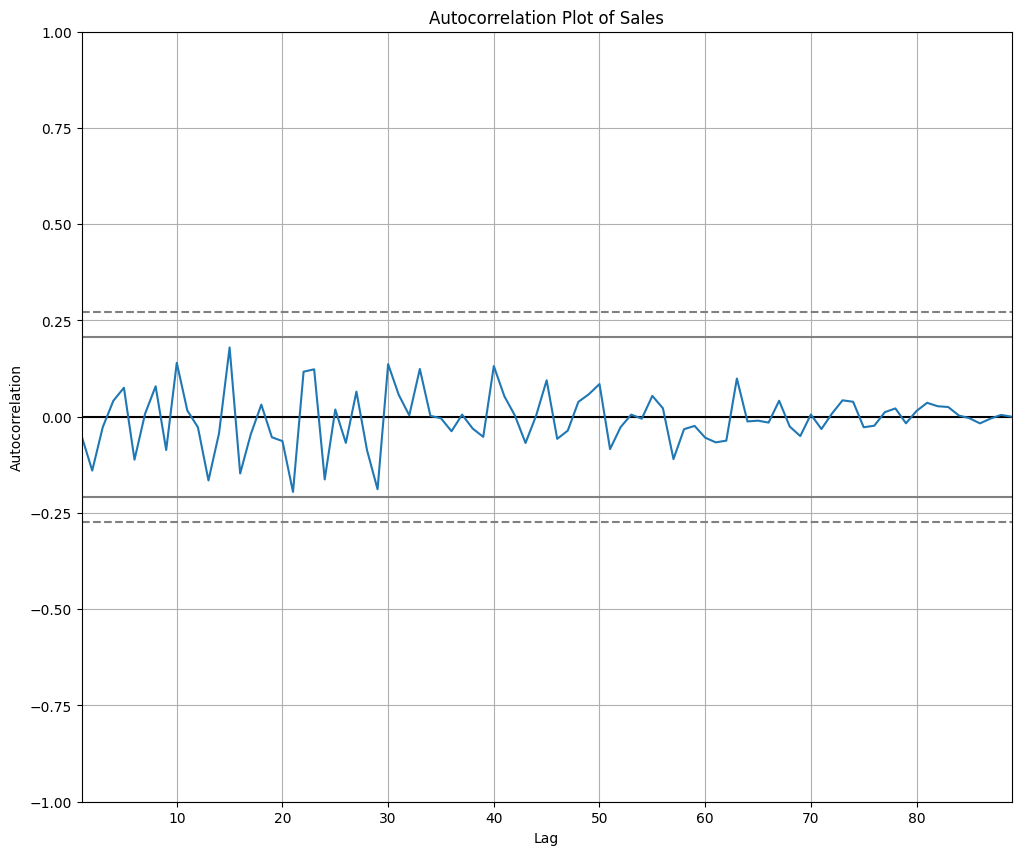

In [68]:
# Autocorrelation

autocorrelation_plot(df_daily.sales)
plt.title('Autocorrelation Plot of Sales')
plt.show()

No significant periodicity or seasonality

In [82]:
#  Daily change ratio
df_daily["change"] = df_daily["sales"].div(df_daily["sales"].shift(7))

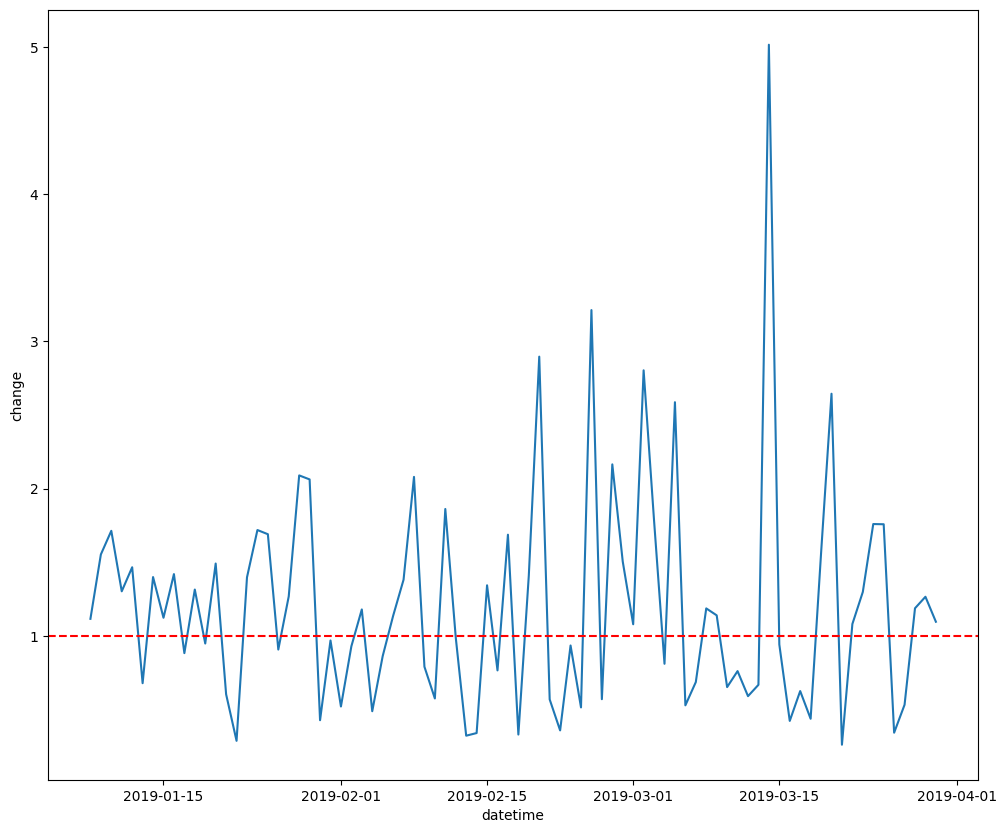

In [83]:
# plt.figure(figsize=(12,6))
sns.lineplot(x=df_daily.index, y=df_daily["change"])
plt.axhline(1, color="red", linestyle="--")  # baseline (no change)
plt.show()

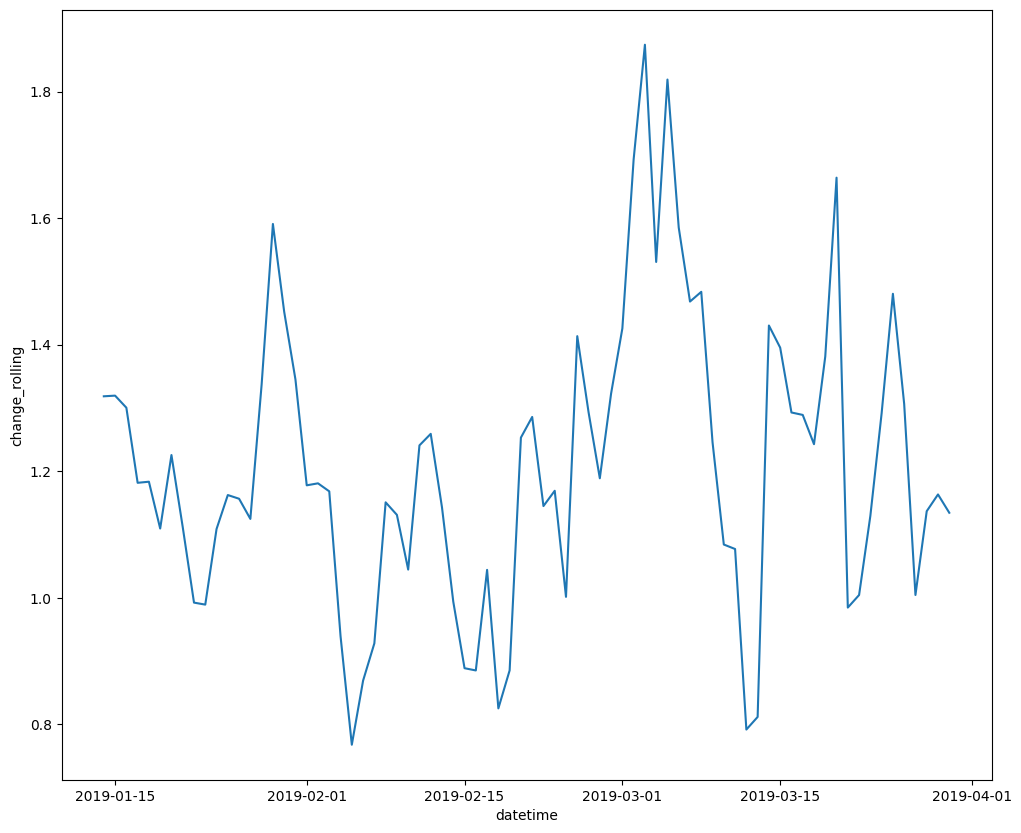

In [84]:
df_daily["change_rolling"] = df_daily["change"].rolling(7).mean()
sns.lineplot(x=df_daily.index, y=df_daily["change_rolling"]);

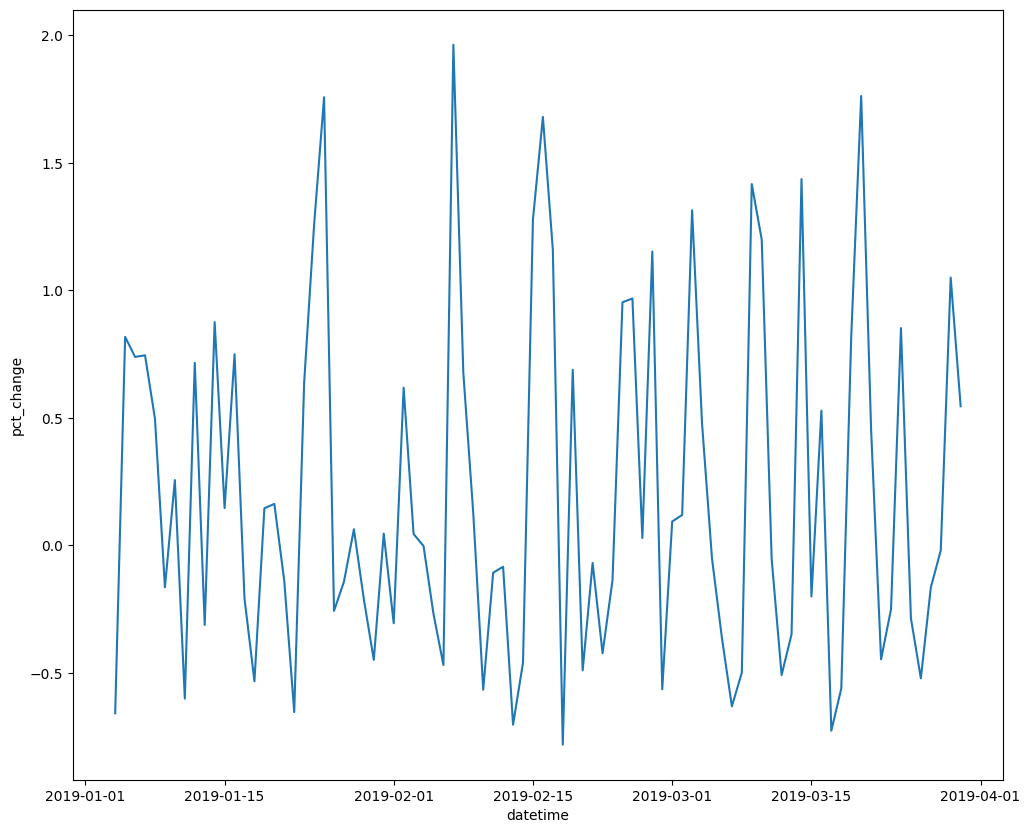

In [85]:
df_daily["pct_change"] = df_daily["sales"].pct_change(periods=3)
sns.lineplot(x=df_daily.index, y=df_daily["pct_change"]);

<Figure size 800x400 with 0 Axes>

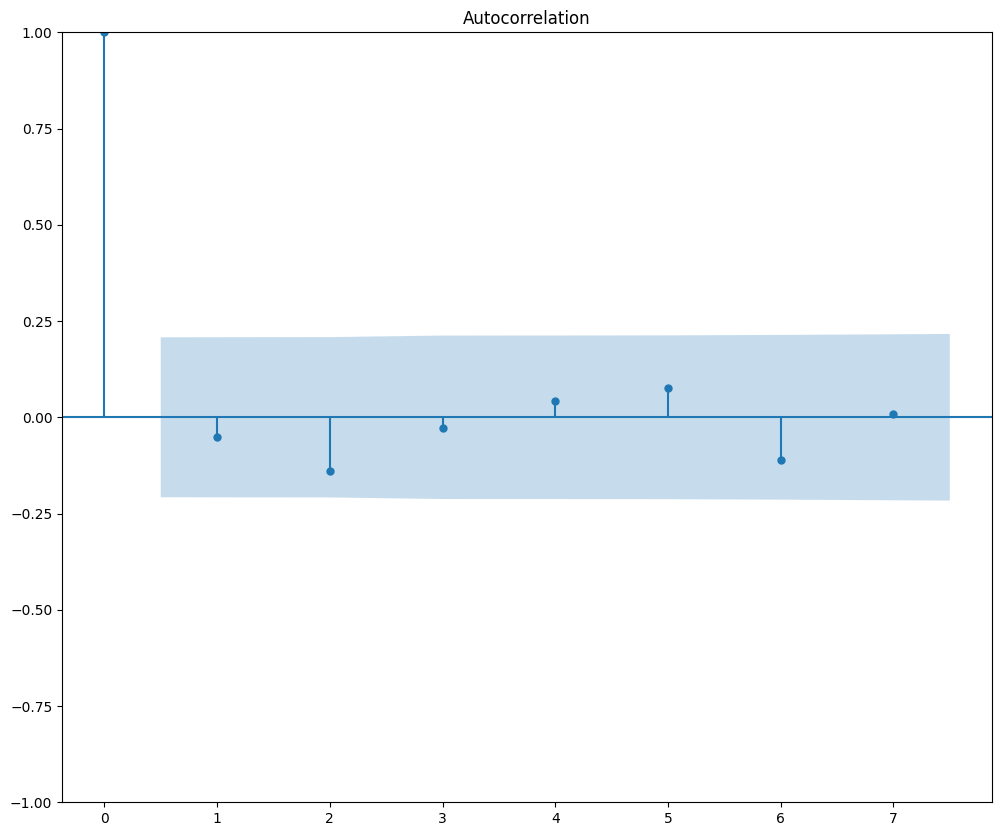

In [86]:
plt.figure(figsize= (8,4))
plot_acf(df_daily["sales"], lags=7) 
plt.show();

**checking up to one week of daily lags, most lags appear within bounds, meaning there’s weak autocorrelation in daily sales.**


<Figure size 800x400 with 0 Axes>

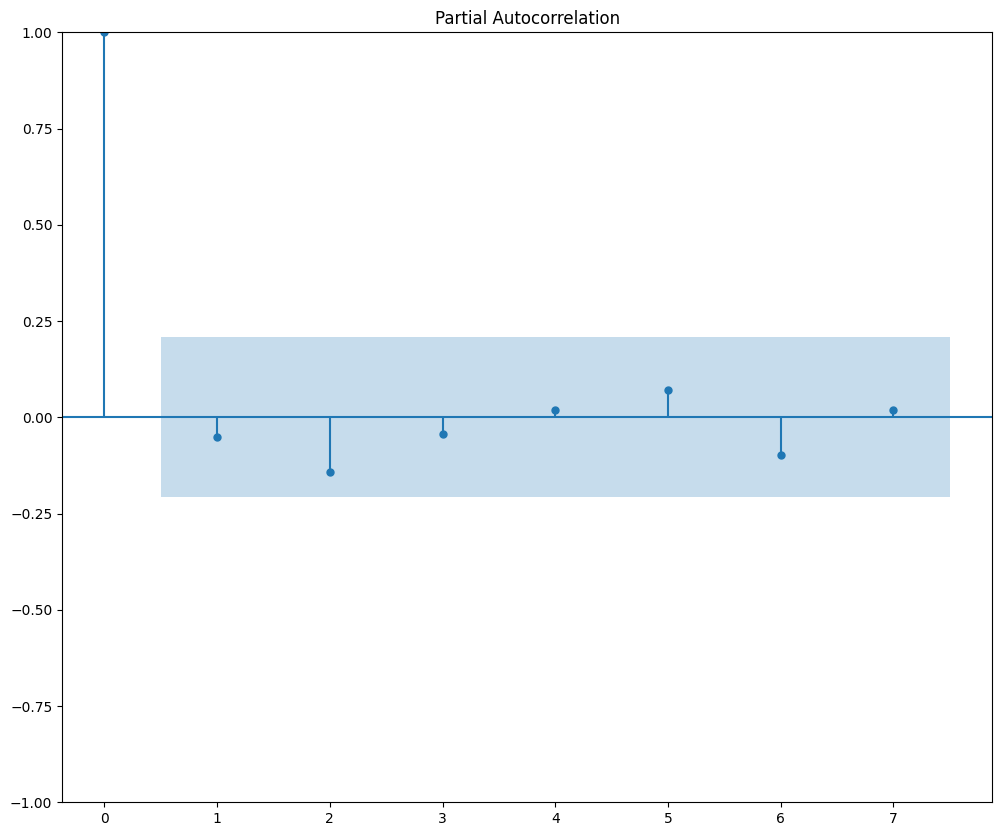

In [87]:
plt.figure(figsize= (8,4))
plot_pacf(df_daily["sales"], lags=7, method="ywm") 
plt.show()

**PACF isolates the direct effect of each lag, removing indirect correlations, only the first lag or two show mild significance, while later lags are within bounds. This implies that short-term dependence (lag-1 or lag-2) may exist.**

In [88]:
# Check for stationarity
# If p-value < 0.05, your series is stationary and ready for ARIMA. 

from statsmodels.tsa.stattools import adfuller

result = adfuller(df_daily['sales'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -7.654895726803344
p-value: 1.7495640309589597e-11
